In [ ]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import gen_features
from sklearn.preprocessing import RobustScaler, MinMaxScaler, KBinsDiscretizer, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression(solver = 'lbfgs', 
                           max_iter = 10000, 
                           random_state = 42)

In [2]:
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = WEB

train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

In [3]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

In [4]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [5]:
target = 'status_group'
train_features = train.drop(columns = [target, 'id'])
features = train_features.columns.tolist()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [6]:
minmax_scaler = MinMaxScaler
rob_scaler = RobustScaler
hash_encoder = ce.HashingEncoder
ordinal_encoder = ce.OrdinalEncoder
one_hot_encoder = ce.OneHotEncoder
binary_encoder = ce.BinaryEncoder
k_bins = KBinsDiscretizer

In [30]:
one_hot_features = gen_features(
    columns = [['extraction_type_class'], ['management_group'], ['source_class'], ['waterpoint_type_group'],
              ['quality_group'], ['quantity'], ['region'], 
              ['scheme_management'], ['basin'], ['lga'], ['management'], ['payment_type']],
    classes = [{'class': one_hot_encoder, 'use_cat_names': 'True'}]
)

scaling_features = gen_features(
    columns = [['gps_height'], ['longitude'], ['latitude'], ['amount_tsh'], ['population']],
    classes = [rob_scaler]
)

no_encode = gen_features(
    columns = [['construction_year'], ['year_recorded']],
    classes = None
)

mapping_features = one_hot_features + scaling_features + no_encode

mapper = DataFrameMapper(mapping_features)

In [31]:
X_train_mapped = mapper.fit_transform(X_train)
X_val_mapped = mapper.transform(X_val)

In [32]:
model_log.fit(X_train_mapped, y_train)
y_pred = model_log.predict(X_val_mapped)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy Score: {accuracy:.3f}')

C:\ProgramData\Anaconda3_\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy Score: 0.745


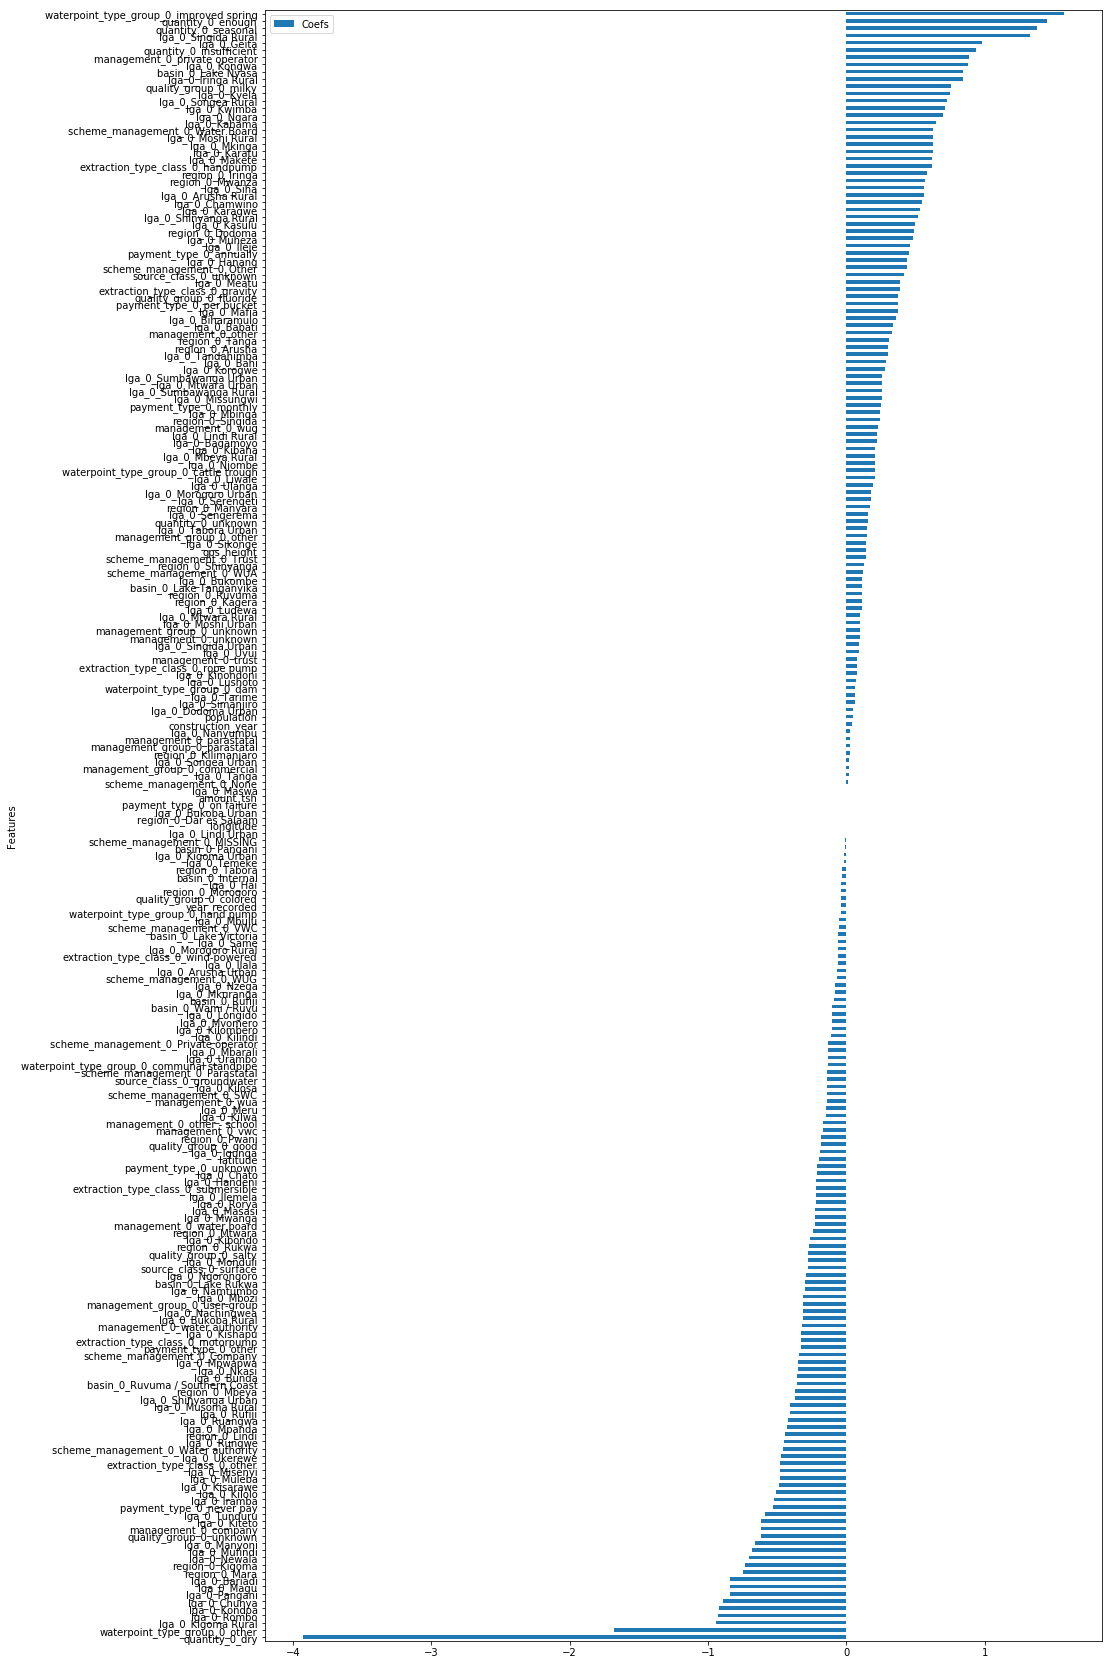

In [33]:
coefs = np.round(model_log.coef_[0], 2)
feature_names = np.array(mapper.transformed_names_)
coefs_df = pd.DataFrame({'Features': feature_names, 'Coefs': coefs})
coefs_df.sort_values(by = 'Coefs').plot.barh(x = 'Features', y = 'Coefs', figsize = (15, 30))

In [34]:
X_test = test
X_test = mapper.transform(X_test)
y_pred = model_log.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('rgolds-submission-5.csv', index = False)

from IPython.display import FileLink, FileLinks
FileLinks('.') #lists all downloadable files on server

./
  decision_trees.ipynb
  Decision_Tree_Assignment.ipynb
  rgolds-submission-2.csv
  rgolds-submission-3.csv
  rgolds-submission-4.csv
  rgolds-submission-5.csv
.\.ipynb_checkpoints/
  decision_trees-checkpoint.ipynb
  Decision_Tree_Assignment-checkpoint.ipynb

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state = 42)

In [36]:
dt.fit(X_train_mapped, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [37]:
y_pred = dt.predict(X_val_mapped)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy Score: {accuracy:.3f}')

Accuracy Score: 0.754


In [38]:
X_test = test
X_test = mapper.transform(X_test)
y_pred = dt.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('rgolds-submission-6.csv', index = False)

from IPython.display import FileLink, FileLinks
FileLinks('.') #lists all downloadable files on server

./
  decision_trees.ipynb
  Decision_Tree_Assignment.ipynb
  rgolds-submission-2.csv
  rgolds-submission-3.csv
  rgolds-submission-4.csv
  rgolds-submission-5.csv
  rgolds-submission-6.csv
.\.ipynb_checkpoints/
  decision_trees-checkpoint.ipynb
  Decision_Tree_Assignment-checkpoint.ipynb